In [15]:
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from scipy.interpolate import RegularGridInterpolator
from FD_functions.functions_3d import pizzo_maccormack, upwind, flux_limiter_upwinds, f_function
import numpy as np
from FD_functions.interpolation import interpolate_initial_condition
from astropy.constants import m_p
import rom_operator_inference as roi
import astropy.units as u
import matplotlib.pyplot as plt
from rom_tools import flatten, undo_flatten, normalize_min_max, qDEIM
import scipy.linalg as la
import matplotlib

font = {'family': 'serif',
        'size': 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

# POD

In [18]:
# FOM solution saved.
FOM_SOL = np.load('data/data.npy')
quantities, n_phi, n_theta, n_radial = np.shape(FOM_SOL)
n_radial

500

In [19]:
# split into testing and training
l = int(0.7 * n_radial)
# reshape the FOM solution
X_train = FOM_SOL[:, :, :, :l]
X_test = FOM_SOL[:, :, :, l:]

In [20]:
# SVD decomposition
svdvals = la.svdvals(flatten(X_train, np=n_phi, nt=n_theta))

In [21]:
#### SIMULATION -- GALERKIN PROJECTION STEP ######
r = (np.linspace(0.14, 1.1, int(n_radial)) * u.AU).to(u.km)
r = r.to(u.km)
dr = r[1] - r[0]
# define mesh grid
PHI, THETA = np.meshgrid(np.linspace(0, 2 * np.pi, n_phi), np.linspace(0.05, np.pi - 0.05, n_theta))

In [34]:
np.arange(15, 100, 35)

array([15, 50, 85])

In [35]:
ell_vector = np.arange(15, 100, 35)
error_vector = np.zeros((len(r)-1, len(ell_vector)))

for pp in range(len(ell_vector)):
    # construct the reduced basis Vr. 
    ell = ell_vector[pp]
    Vr, _ = roi.pre.pod_basis(flatten(X_train, np=n_phi, nt=n_theta), ell, mode="dense")

    ROM_SOL = np.zeros((5, n_phi, n_theta, len(r)))
    ROM_SOL[:, :, :, 0] = FOM_SOL[:, :, :, 0]

    for ii in range(len(r) - 1):
        nonlinear = Vr.T @ flatten(f_function(U=ROM_SOL[:, :, :, ii],
                                              dp=(2 * np.pi) / n_phi,
                                              dt=np.pi / n_theta,
                                              r=r[ii], THETA=THETA.T),
                                   np=n_phi, nt=n_theta, vector=True)
        reduce_solution = Vr.T @ flatten(ROM_SOL[:, :, :, ii],
                                         np=n_phi, nt=n_theta, vector=True) + \
                          dr.value * nonlinear
        ROM_SOL[:, :, :, ii + 1] = undo_flatten(Vr @ reduce_solution, np=n_phi, nt=n_theta, vector=True)
        
        RE = (ROM_SOL[:, :, :, ii + 1] - FOM_SOL[:, :, :, ii + 1])/(FOM_SOL[:, :, :, ii + 1])
        error_vector[ii, pp] = np.mean(RE)

In [36]:
r.to(u.AU).value[l]

0.8133466933867735

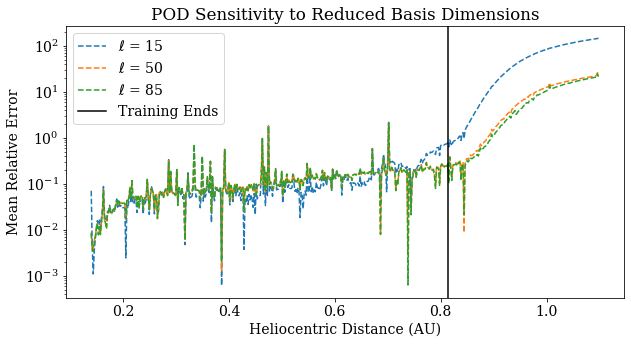

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
for pp in range(len(ell_vector)):
    
    ax.plot(r.to(u.AU).value[:-1], np.abs(error_vector[:, pp]), "--", label="$\ell$ = " + str(int(ell_vector[pp])))
ax.axvline(r.to(u.AU).value[l], c="black", label="Training Ends")
ax.set_yscale("log")
#ax.set_ylim(0, 100)
ax.set_title("POD Sensitivity to Reduced Basis Dimensions")
ax.set_xlabel("Heliocentric Distance (AU)")
ax.set_ylabel("Mean Relative Error")
plt.legend()
plt.savefig("figs_rom/sesitivity_to_ell_b.png", dpi=400)

# DEIM

In [ ]:
k_vec = np.arange(20, 200, 50)
error_vector_k = np.zeros((len(r)-1, len(k_vec)))
Vr, _ = roi.pre.pod_basis(flatten(X_train, np=n_phi, nt=n_theta), 15, mode="dense")

for pp in range(len(k_vec)):
    U = np.load('data/U_full.npy')
    U = U[:, :k_vec[pp]]
    S, _ = qDEIM(U)
    mat_mul = Vr.T @ U @ np.linalg.inv(S.T @ U) @ S.T
    ROM_SOL_DEIM = np.zeros((5, n_phi, n_theta, len(r)))
    ROM_SOL_DEIM[:, :, :, 0] = FOM_SOL[:, :, :, 0]

    for ii in range(len(r) - 1):
        f_vx = flatten(f_function(U=ROM_SOL_DEIM[:, :, :, ii],
                                  dp=(2 * np.pi) / n_phi,
                                  dt=np.pi / n_theta,
                                  r=r[ii], THETA=THETA.T),
                       np=n_phi, nt=n_theta, vector=True)

        nonlinear = mat_mul @ f_vx

        reduce_solution = Vr.T @ flatten(ROM_SOL_DEIM[:, :, :, ii],
                                         np=n_phi, nt=n_theta, vector=True) + \
                          dr.value * nonlinear

        ROM_SOL_DEIM[:, :, :, ii + 1] = undo_flatten(Vr @ reduce_solution, np=n_phi, nt=n_theta, vector=True)
        RE = (ROM_SOL_DEIM[:, :, :, ii + 1] - FOM_SOL[:, :, :, ii + 1])/(FOM_SOL[:, :, :, ii + 1])
        error_vector_k[ii, pp] = np.mean(RE)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
for pp in range(len(ell_vector)):
    ax.plot(r.to(u.AU).value[:-1], np.abs(error_vector_k[:, pp]), "--", label="$k$ = " + str(int(k_vec[pp])))
ax.axvline(r.to(u.AU).value[l], c="black", label="Training Ends")
ax.set_ylim(0, 100)

ax.set_yscale("log")
ax.set_title("POD-DEIM Sensitivity to Number of Sampling Points")
ax.set_xlabel("Heliocentric Distance (AU)")
ax.set_ylabel("Mean Relative Error")
plt.legend()
plt.savefig("figs_rom/sesitivity_to_k.png", dpi=400)

In [30]:
U = np.load('data/U_full.npy')
np.shape(U)


(301000, 300)

In [31]:
S, _ = qDEIM(U)
np.shape(S)

(301000, 300)

In [32]:
mat_mul = Vr.T @ U @ np.linalg.inv(S.T @ U) @ S.T
np.shape(mat_mul)

(60, 301000)

In [33]:
ROM_SOL_DEIM = np.zeros((5, n_phi, n_theta, len(r)))
ROM_SOL_DEIM[:, :, :, 0] = FOM_SOL[:, :, :, 0]

jj = 0
for ii in range(len(r) - 1):
    f_vx = flatten(f_function(U=ROM_SOL_DEIM[:, :, :, ii],
                              dp=(2 * np.pi) / n_phi,
                              dt=np.pi / n_theta,
                              r=r[ii], THETA=THETA.T),
                   np=n_phi, nt=n_theta, vector=True)

    nonlinear = mat_mul @ f_vx

    reduce_solution = Vr.T @ flatten(ROM_SOL_DEIM[:, :, :, ii],
                                     np=n_phi, nt=n_theta, vector=True) + \
                      dr.value * nonlinear

    ROM_SOL_DEIM[:, :, :, ii + 1] = undo_flatten(Vr @ reduce_solution, np=n_phi, nt=n_theta, vector=True)

KeyboardInterrupt: 